This software was created by William Marsh Rice University under Army Research Office (ARO) 
Award Number W911NF-24-2-0008 and W911NF-19-2-0269. ARO, as the Federal awarding agency, reserves 
a royalty-free, nonexclusive and irrevocable right to reproduce, publish, or otherwise use this 
software for Federal purposes, and to authorize others to do so in accordance with 2 CFR 200.315(b).


In [1]:
import os
import sys
import time
import networkx as nx
import scipy.io as sio
import scipy.sparse as sp
from scipy.spatial import distance_matrix
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation

import pickle

%matplotlib inline

import re
numeric_const_pattern = r"""
     [-+]? 
     (?:
         (?: \d* \. \d+ )
         |
         (?: \d+ \.? )
     )
     (?: [Ee] [+-]? \d+ ) ?
     """
rx = re.compile(numeric_const_pattern, re.VERBOSE)

from IPython.display import clear_output
from IPython.display import Video

from scipy.stats.stats import pearsonr


In [2]:
def add_patch(legend):
    from matplotlib.patches import Patch
    ax = legend.axes

    handles, labels = ax.get_legend_handles_labels()
    handles.append(Patch(facecolor='white', edgecolor='white', alpha=0.1))
    labels.append(" ")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())


In [3]:
outdir = '../out'

## Trajectory & Monitoring

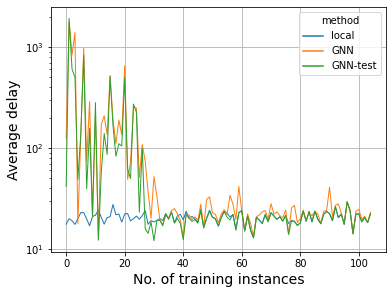

In [4]:
output_csv = os.path.join(outdir, "aco_training_data_aco_data_ba_200_load_0.15_T_1000.csv")


while True:
    fig, ax = plt.subplots(1, 1, sharey=False, figsize=(6, 4.5))
    df = pd.read_csv(output_csv, index_col=False)
    df.index.name = "order"
    df_train = df.groupby(['fid','method']).mean()

    sns.lineplot(
        x="fid", y="tau", 
        data=df_train, 
        hue="method",
#         hue_order=["baseline","local","GNN"],
        hue_order=["local","GNN", "GNN-test"],
        linewidth=1.0, 
        palette="tab10", 
        markers=True,
        markersize=16,
        ax=ax,
    )

    plt.yscale('log')
    ax.grid(True)
    ax.set_xlabel('No. of training instances', fontsize=14)
    ax.set_ylabel("Average delay", fontsize=14)
    plt.show()
#     time.sleep(30)
#     clear_output()
    break


In [5]:
filename = 'Adhoc_test_data_aco_data_ba_100_load_0.15_T_1000'
# filename = 'Adhoc_test_data_aco_data_ba_100_load_0.20_T_1000'
# output_csv = os.path.join(outdir, 'Adhoc_test_data_aco_data_ba_10_load_0.10_T_1000.csv')
output_csv = os.path.join(outdir, filename + '.csv')
# output_csv = os.path.join(outdir, 'Adhoc_test_data_aco_data_ba_10_load_0.15_T_800.csv')
# df.to_csv(output_csv, index=False)
df = pd.read_csv(output_csv, index_col=False)
df_res = df

In [6]:
# df.groupby(['num_nodes',"Algo"]).mean()
df.groupby(["Algo"]).mean()

,seed,num_nodes,m,num_mobile,num_servers,num_relays,num_jobs,n_instance,runtime,tau,congest_jobs,gnn_bl_ratio,gap_2_bl
Algo,,,,,,,,,,,,,
GNN,549.5,65.0,2.0,51.978,11.126,1.896,33.0394,4.5,0.110571,18.436329,0.0026,1.910553,-270.290822
baseline,549.5,65.0,2.0,51.978,11.126,1.896,33.0394,4.5,0.039173,288.727152,4.7443,1.000000,0.000000
local,549.5,65.0,2.0,51.978,11.126,1.896,33.0394,4.5,0.001890,20.362447,0.0000,2.241962,-268.364704


In [7]:
# Run only one time for post processing data
df_res = pd.DataFrame(columns=
    ["filename", "seed", "num_nodes", "m", "num_mobile", "num_servers", "num_relays", "num_jobs", "n_instance",
     "Algo", "runtime", "tau", "congest_jobs", "gnn_bl_ratio"
    ]
)
for col in ["filename", "seed", "num_nodes", "m", "num_mobile", "num_servers", "num_relays", "num_jobs", "n_instance"]:
    df_res[col]=df[col]

    
df_res0 = df_res.copy(deep=True)
df_res1 = df_res.copy(deep=True)
df_res0["Algo"]="Baseline"
df_res0["runtime"] = df["runtime_b"]
df_res0["tau"] = df["tau_bl"]
df_res0["congest_jobs"] = df["congest_jobs_bl"]
df_res0["gnn_bl_ratio"] = 1.0

df_res1["Algo"]="GNN"
df_res1["runtime"] = df["runtime_g"]
df_res1["tau"] = df["tau_gnn"]
df_res1["congest_jobs"] = df["congest_jobs_gnn"]
df_res1["gnn_bl_ratio"] = df["gnn_bl_ratio"]

df_res = pd.concat([df_res0, df_res1], ignore_index=True)   

df_res


KeyError: 'runtime_b'

##  Fig.2(a) Scale of instances by network sizes

../fig/Adhoc_Adhoc_test_data_aco_data_ba_100_load_0.15_T_1000_instance_scales.pdf


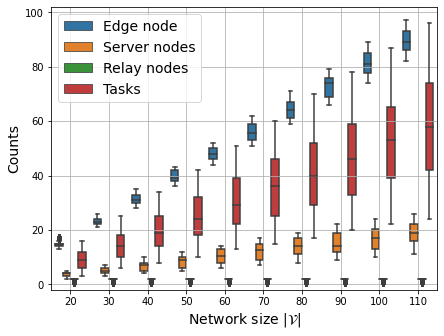

In [10]:
fname = '../fig/Adhoc_{}_instance_scales.pdf'.format(filename)

fig, ax = plt.subplots(1, 1, sharey=False, figsize=(6, 4.5))

lgds = {
    "num_mobile": "Edge node",
    "num_servers": "Server nodes",
    "num_relays": "Relay nodes",
    "num_jobs": "Tasks"
}

df_tmp = pd.DataFrame(columns=["network_size", "item", "num_nodes"])
df_tmp["network_size"]=df["num_nodes"]
df_t0 = df_tmp.copy(deep=True)
df_t1 = df_tmp.copy(deep=True)
df_t2 = df_tmp.copy(deep=True)
df_t3 = df_tmp.copy(deep=True)
l_df = [df_t0, df_t1, df_t2, df_t3]

i=0
for item in ["num_mobile","num_servers","num_relays","num_jobs"]:
    l_df[i]["item"] = lgds[item]
    l_df[i]["num_nodes"] = df[item]
    i+=1

df_tmp = pd.concat(l_df, ignore_index=True)  

# sns.scatterplot(
#     x="network_size", y="num_nodes", 
#     data=df_tmp, 
#     hue="item",
#     hue_order=["num_mobile","num_servers","num_relays","num_jobs"],
#     style="item",
#     style_order=["num_mobile","num_servers","num_relays","num_jobs"],
#     # linewidth=2.0, 
#     palette="tab10", 
#     markers=True,
#     ax=ax,
# )

sns.boxplot(
    data=df_tmp, x="network_size", y="num_nodes", hue="item",
    hue_order=["Edge node","Server nodes","Relay nodes","Tasks"],
#     style="item",
#     style_order=["num_mobile","num_servers","num_relays","num_jobs"],
    palette="tab10", 
    ax=ax,
)

L = ax.legend(
    fontsize=14,
#     framealpha=0.3,
#     ncol=1,
#     loc='upper center',
)

ax.set_ylim([-2, 102])
ax.grid(True)
# ax.set_xlabel('Network size ($|\mathcal{V}|$)', fontsize=14)
ax.set_xlabel('Network size $|\mathcal{V}|$', fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
print(fname)
fig.set_size_inches(6, 4.5)
plt.tight_layout(pad=0.1)
fig.savefig(fname,
            dpi=300,  # facecolor='w', edgecolor='w',
            orientation='portrait',
            format='pdf')

## Fig.2(b) Task congestion probability and execution latency by network size  

In [11]:
# df_con = df_res.groupby("filename")
df_res["congest_ratio"] = 100*df_res["congest_jobs"]/df_res["num_jobs"]
df_res["wt_response_ratio"] = df_res["gnn_bl_ratio"]*df_res["num_jobs"]
df_con = df_res.groupby(["filename","Algo"]).mean()
# df_con_sum = df_res[df_res["Algo"]=="GNN"].groupby(["filename","Algo"]).sum()
df_con_sum = df_res.groupby(["filename","Algo"]).sum()
df_con_sum["response_ratio"] = df_con_sum["wt_response_ratio"] / df_con_sum["num_jobs"]
df_con_sum["num_nodes"] = df_con_sum["num_nodes"] / 10
# df_con_sum["type"] = "GNN"
df_con_sum = df_con_sum.reset_index(level=("Algo",))

df_con_sum

,Algo,seed,num_nodes,m,num_mobile,num_servers,num_relays,num_jobs,n_instance,runtime,tau,congest_jobs,gnn_bl_ratio,gap_2_bl,congest_ratio,wt_response_ratio,response_ratio
filename,,,,,,,,,,,,,,,,,
aco_case_seed500_m2_n100_s11.mat,GNN,5000,100.0,20,870,110,20,508,45,1.335835,201.182959,0,12.481075,-5920.818027,0.000000,596.341255,1.173900
aco_case_seed500_m2_n100_s11.mat,baseline,5000,100.0,20,870,110,20,508,45,0.773580,6122.000986,139,10.000000,0.000000,245.360074,508.000000,1.000000
aco_case_seed500_m2_n100_s11.mat,local,5000,100.0,20,870,110,20,508,45,0.021433,222.877448,0,15.542289,-5899.123538,0.000000,746.631532,1.469747
aco_case_seed500_m2_n110_s22.mat,GNN,5000,110.0,20,860,220,20,495,45,1.430002,173.649628,0,23.328627,-451.351557,0.000000,1124.369035,2.271453
aco_case_seed500_m2_n110_s22.mat,baseline,5000,110.0,20,860,220,20,495,45,0.771507,625.001186,18,10.000000,0.000000,29.377502,495.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aco_case_seed599_m2_n80_s10.mat,baseline,5990,80.0,20,680,100,20,402,45,0.500565,3573.642973,49,10.000000,0.000000,117.584693,402.000000,1.000000
aco_case_seed599_m2_n80_s10.mat,local,5990,80.0,20,680,100,20,402,45,0.021125,213.735746,0,20.560745,-3359.907227,0.000000,788.090663,1.960425
aco_case_seed599_m2_n90_s11.mat,GNN,5990,90.0,20,770,110,20,559,45,1.548385,147.129066,0,13.125983,-2078.255453,0.000000,701.721047,1.255315


../fig/Adhoc_Adhoc_test_data_aco_data_ba_100_load_0.15_T_1000_task_congestion_latency.pdf


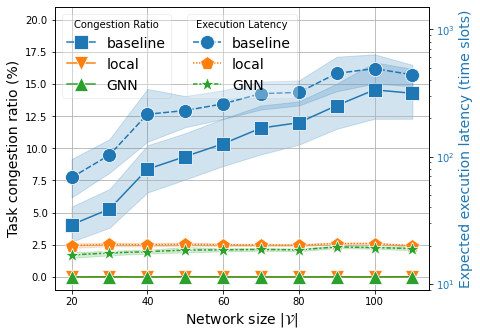

In [12]:
# fname = '../fig/Adhoc_{}_task_response_pct.pdf'.format("Adhoc_test_data_aco_data_ba_10_load_0_10_T_1000")
# fname = '../fig/Adhoc_{}_task_congestion_ratio.pdf'.format("Adhoc_test_data_aco_data_ba_10_load_0_15_T_800")
fname = '../fig/Adhoc_{}_task_congestion_latency.pdf'.format(filename)

fig, ax = plt.subplots(1, 1, sharey=False, figsize=(6, 4.5))

ax2 = ax.twinx()
# ax2.set_facecolor('none')

sns.lineplot(
    data=df_con, x="num_nodes", y="congest_ratio", hue="Algo",
    hue_order=["baseline","local","GNN"],
    style="Algo",
    style_order=["baseline","local","GNN"],
    palette="tab10", 
    markers=["s", "v", "^"],
    # markers=True,
    markersize=14,
    dashes=False,
    ax=ax,
)

sns.lineplot(
    data=df_con, x="num_nodes", y="tau", hue="Algo",
    hue_order=["baseline","local","GNN"],
    style="Algo",
    style_order=["non","baseline","local","GNN"],
#     style="m",
#     style_order=[1.0, 3.0, 2.0],
    palette="tab10", 
    markers=["o", "o", "p", "*"],
    markersize=14,
#     linestyle="dotted",
    ax=ax2,
)
ax2.set_yscale('log')

L = ax.legend(
    ["baseline","local","GNN"],
    fontsize=14,
    framealpha=0.3,
#     ncol=1,
    loc='upper left',
    title='Congestion Ratio'
)


L2 = ax2.legend(
    ["baseline","local","GNN"],
    fontsize=14,
    framealpha=0.3,
#     ncol=1,
    loc='upper center',
    title='Execution Latency'
)
ax2.set_ylim([9, 1500])
color = 'tab:blue'
# ax2.grid(True, color="tab:gray")
ax2.set_ylabel("Expected execution latency (time slots)", fontsize=14, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# ax.set_ylim([-1, 31])
ax.set_ylim([-1, 21])
# ax.get_legend().remove()
ax.grid(True)
ax.set_xlabel('Network size $|\mathcal{V}|$', fontsize=14)
ax.set_ylabel("Task congestion ratio (%)", fontsize=14)
print(fname)
fig.set_size_inches(6.5, 4.5)
plt.tight_layout(pad=0.1)
fig.savefig(fname,
            dpi=300,  # facecolor='w', edgecolor='w',
            orientation='portrait',
            format='pdf')


In [242]:
df_con_sum.reset_index(level=("Algo",))

,Algo,seed,num_nodes,m,num_mobile,num_servers,num_relays,num_jobs,n_instance,runtime,tau,congest_jobs,gnn_bl_ratio,gap_2_bl,congest_ratio,wt_response_ratio,response_ratio
filename,,,,,,,,,,,,,,,,,
aco_case_seed500_m2_n100_s18.mat,GNN,5000,100.0,20,800,180,20,525,45,1.276345,202.413803,0,20.449451,-1225.385888,0.000000,1036.745407,1.974753
aco_case_seed500_m2_n100_s18.mat,baseline,5000,100.0,20,800,180,20,525,45,0.691014,1427.799691,43,10.000000,0.000000,70.698254,525.000000,1.000000
aco_case_seed500_m2_n100_s18.mat,local,5000,100.0,20,800,180,20,525,45,0.022305,203.428422,0,20.582591,-1224.371269,0.000000,1046.008970,1.992398
aco_case_seed500_m2_n110_s18.mat,GNN,5000,110.0,20,900,180,20,590,45,1.377164,213.953722,0,19.390638,-2169.642710,0.000000,1057.699503,1.792711
aco_case_seed500_m2_n110_s18.mat,baseline,5000,110.0,20,900,180,20,590,45,0.887068,2383.596432,80,10.000000,0.000000,113.027932,590.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aco_case_seed509_m2_n70_s8.mat,baseline,5090,70.0,20,600,80,20,338,45,0.342158,12137.637729,105,10.000000,0.000000,268.136754,338.000000,1.000000
aco_case_seed509_m2_n70_s8.mat,local,5090,70.0,20,600,80,20,338,45,0.017345,227.797361,0,12.888502,-11909.840367,0.000000,392.137163,1.160169
aco_case_seed509_m2_n80_s9.mat,GNN,5090,80.0,20,690,90,20,388,45,1.090266,191.748438,0,16.027534,-10536.070977,0.000000,551.279197,1.420823


## Fig. 2(c) Average per-task execution latency ratio w.r.t. the baseline policy 

../fig/Adhoc_Adhoc_test_data_aco_data_ba_100_load_0.15_T_1000_task_response_pct.pdf


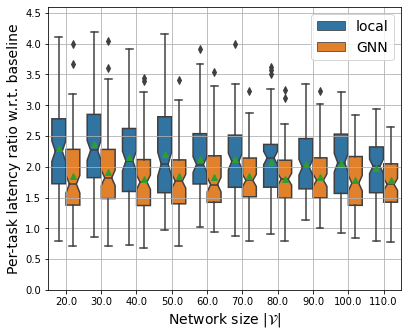

In [13]:
fname = '../fig/Adhoc_{}_task_response_pct.pdf'.format(filename)

fig, ax = plt.subplots(1, 1, sharey=False, figsize=(6, 4.5))

# ax2 = ax.twinx()
# ax2.set_facecolor('none')


sns.boxplot(
    data=df_con_sum, x="num_nodes", y="response_ratio",
    hue="Algo",
    hue_order=["local","GNN"],
    notch=True,
    showmeans=True,
#     style="item",
#     style_order=["num_mobile","num_servers","num_relays","num_jobs"],
    # palette="tab10", 
    # facecolor=None,
    ax=ax,
)
# ax2.boxplot(
#     df,
#     notch=True,  # notch shape
#     vert=True,  # vertical box alignment
#     patch_artist=True,  # fill with color
#     labels=labels
# ) 


L = ax.legend(
    fontsize=14,
#     framealpha=0.3,
#     ncol=1,
    loc='upper right',
)

# ax.set_ylim([-2, 25])
# ax.get_legend().remove()
# ax.set_ylim([0, 27.6])
ax.set_ylim([0, 4.6])
ax.set_yticks(np.arange(0,4.6,0.5))
ax.grid(True)
ax.set_xlabel('Network size $|\mathcal{V}|$', fontsize=14)
ax.set_ylabel("Per-task latency ratio w.r.t. baseline", fontsize=14)
print(fname)
fig.set_size_inches(5.5, 4.5)
plt.tight_layout(pad=0.1)
fig.savefig(fname,
            dpi=300,  # facecolor='w', edgecolor='w',
            orientation='portrait',
            format='pdf')
